In [50]:
import numpy as np
import pandas as pd
import itertools
import random
from tqdm import tqdm
from ast import literal_eval
import time

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import joblib
device = torch.device("cpu")

import matplotlib.pyplot as plt

In [51]:
plt.style.use('seaborn-v0_8')
plt.rcParams["grid.linestyle"] = "--"

plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.facecolor'] = "lavender"

In [52]:
config_dict = {
    0: "fair",
    1: "cheat-1_no-cooldown",
    2: "cheat-2_no-dash",
    3: "cheat-3_inf-slowmo",
    4: "cheat-4_huge-damage",
    5: "cheat-5_frozen-ninja",
}

In [53]:
def preprocess_gt_csv(data_name):
    filename = f"train_data/gt/{data_name}.csv"

    columns_to_eval = [
        "global_mouse_position",
        "button_cooldown_times",
        "logical_frames_since_last_button_press",
        "global_position",
        "velocity",
        "fruits_cut_this_frame_list",
        "fruits_hit_ninjas_ass_this_frame_list",
        "fruits_on_screen_this_frame_list",
        "fruits_spawned_this_frame_list",
        "stupid_fucking_fruits_that_died_this_frame_list",
    ]

    df = pd.read_csv(filename, converters={column: literal_eval for column in columns_to_eval})

    df["fruits_spawned_num"] = df["fruits_spawned_this_frame_list"].str.len()
    df["fruits_on_screen_num"] = df["fruits_on_screen_this_frame_list"].str.len()
    df["fruits_hit_num"] = df["fruits_hit_ninjas_ass_this_frame_list"].str.len()
    df["fruits_missed_num"] = df["stupid_fucking_fruits_that_died_this_frame_list"].str.len()

    projectiles = ["Apple", "Banana", "Grape", "Pineapple", "Watermelon", "Coconut", "Cherry"]

    df["fruit_name_spawned"] = df["fruits_spawned_this_frame_list"].apply(lambda x: projectiles.index(x[0]["name"]) if len(x) != 0 else -1)

    for butt in ["b1", "b2", "b3", "b4"]:
        df[butt] = df["button_cooldown_times"].apply(lambda j: j[butt])

    general_needed = [
        "cheat_flag",
        "frame_count",
        "session_id",
        "score",
        "combo",
        "is_combo_going",
        "time_left_seconds",
        "can_dash",
    ]
    buttons_needed = [
        "b1", "b2", "b3", "b4",
    ]

    df = df[general_needed + buttons_needed]
    df[general_needed] = df[general_needed].astype(int)

    if data_name == "cheat-4_huge-damage":  # its too fucking huge
        df["score"] *= 0.0001

    return df

In [54]:
def preprocess_synthetic_csv(data_name):
    filename = f"train_data/synthetic/{data_name}_50-games.csv"
    df = pd.read_csv(filename).drop(["Unnamed: 0"], axis=1)
    return df

In [55]:
synthetic_data = pd.concat([preprocess_synthetic_csv(data_name) for data_name in config_dict.values()])

X_synthetic = synthetic_data.drop(["cheat_flag", "session_id"], axis=1)
y_synthetic = synthetic_data["cheat_flag"]

X_synthetic.shape, y_synthetic.shape

((1979694, 10), (1979694,))

In [56]:
gt_data = pd.concat([preprocess_gt_csv(data_name) for data_name in config_dict.values()])

X_gt = gt_data.drop(["cheat_flag", "session_id"], axis=1)
y_gt = gt_data["cheat_flag"]

X_gt.shape, y_gt.shape

((173006, 10), (173006,))

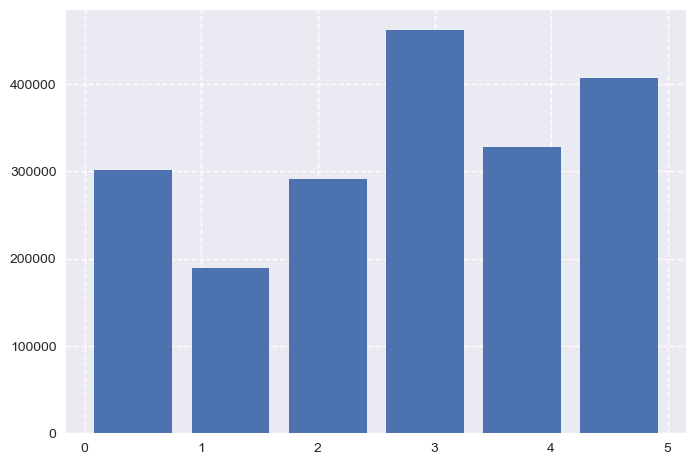

In [57]:
plt.hist(y_synthetic, bins=len(config_dict), rwidth=0.8);

In [58]:
fair_synth = np.sum(y_synthetic == 0)
fair_gt = np.sum(y_gt == 0)

fair_synth, fair_synth / len(y_synthetic)

(301912, 0.1525043769390623)

In [59]:
cheat_synth = int(fair_synth / 5)
cheat_gt = int(fair_gt / 5)
cheat_synth, cheat_gt

(60382, 7906)

In [60]:
def preprocess_normed_synthetic_csv(data_name):
    df = preprocess_synthetic_csv(data_name)
    if data_name != "fair":
        df = df.sample(n=cheat_synth)
        df["cheat_flag"] = 1
    return df

def preprocess_normed_gt_csv(data_name):
    df = preprocess_gt_csv(data_name)
    if data_name != "fair":
        df = df.sample(n=cheat_gt)
        df["cheat_flag"] = 1
    return df

In [61]:
rows_concat = 30

In [62]:
synthetic_data = pd.concat([preprocess_normed_synthetic_csv(data_name) for data_name in config_dict.values()])
synthetic_data.shape

(603822, 12)

In [63]:
synthetic_data = synthetic_data.sample(n=len(synthetic_data) - len(synthetic_data) % rows_concat).sort_values(by=["cheat_flag", "session_id", "frame_count"])
synthetic_data.shape

(603810, 12)

In [64]:
X_synthetic = synthetic_data.drop(["cheat_flag", "session_id"], axis=1)
y_synthetic = synthetic_data["cheat_flag"]

X_synthetic = X_synthetic.to_numpy().reshape((-1, 10 * rows_concat))
y_synthetic = y_synthetic.to_numpy().reshape((-1, 1 * rows_concat))

X_synthetic.shape, y_synthetic.shape

((20127, 300), (20127, 30))

In [65]:
gt_data = pd.concat([preprocess_normed_gt_csv(data_name) for data_name in config_dict.values()])
gt_data.shape

(79064, 12)

In [66]:
gt_data = gt_data.sample(n=len(gt_data) - len(gt_data) % rows_concat).sort_values(by=["cheat_flag", "session_id", "frame_count"])
gt_data.shape

(79050, 12)

In [67]:
X_gt = gt_data.drop(["cheat_flag", "session_id"], axis=1)
y_gt = gt_data["cheat_flag"]

X_gt = X_gt.to_numpy().reshape((-1, 10 * rows_concat))
y_gt = y_gt.to_numpy().reshape((-1, 1 * rows_concat))

X_gt.shape, y_gt.shape

((2635, 300), (2635, 30))

In [68]:
mix_num = len(X_gt) // 4

gt_idx = np.random.choice(len(X_gt), replace=False, size=mix_num)

gt_rest = [i for i in np.arange(len(X_gt)) if i not in gt_idx]

X_train_mixed = np.concatenate([X_synthetic, X_gt[gt_idx]])
y_train_mixed = np.concatenate([y_synthetic, y_gt[gt_idx]])

X_test = X_gt[gt_rest]
y_test = y_gt[gt_rest]

X_train_mixed.shape, y_train_mixed.shape, X_test.shape, y_test.shape

((20785, 300), (20785, 30), (1977, 300), (1977, 30))

In [69]:
train_set = TensorDataset(
    torch.FloatTensor(X_train_mixed).unsqueeze(1),
    torch.LongTensor(y_train_mixed),
)
train_loader = DataLoader(train_set, batch_size=60, shuffle=True)

test_set = TensorDataset(
    torch.FloatTensor(X_test).unsqueeze(1),
    torch.LongTensor(y_test),
)
test_loader = DataLoader(test_set, batch_size=60, shuffle=True)

In [70]:
names = [
    "Decision Tree",
    "Random Forest",
]

classifiers = [
    DecisionTreeClassifier( random_state=42),
    RandomForestClassifier(random_state=42),
]

In [71]:
for name, clf in zip(names, classifiers):
    print(f"{name} model:")

    train_acc = 0
    start = time.time()

    for X, y in tqdm(train_loader):
        clf.fit(X.numpy().squeeze(), y.numpy())
        train_acc += clf.score(X.numpy().squeeze(), y.numpy())

    end = time.time()
    train_acc /= len(train_loader)

    test_acc = 0
    for X, y in tqdm(test_loader):
        test_acc += clf.score(X.numpy().squeeze(), y.numpy())
    test_acc /= len(test_loader)

    # snake_case_name = "_".join(name.lower().split(" "))
    # joblib.dump(clf, f"../microservices/DataManager/weights/binary/{snake_case_name}.joblib")
    # print(f"Saved model.")

    print(f"Train time: {(end - start):.1f} sec,  Train score: {train_acc:.3f},  Gt score: [ {test_acc:.3f} ]")
    print("-" * 150)

Decision Tree model:


100%|██████████| 33/33 [00:00<00:00, 1420.40it/s]


Train time: 3.6 sec,  Train score: 1.000,  Gt score: [ 0.589 ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest model:


100%|██████████| 33/33 [00:00<00:00, 45.41it/s]

Train time: 44.1 sec,  Train score: 1.000,  Gt score: [ 0.524 ]
------------------------------------------------------------------------------------------------------------------------------------------------------


In [25]:
input_size = 10 * rows_concat
hidden_size = 50
output_size = rows_concat
num_layers = 1

learning_rate = 0.001
num_epochs = 50
batch_size = 60

In [28]:
from microservices.DataManager.models.lstm import LSTMModel, LSTM2

model = LSTM2(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=5, threshold=1, factor=0.8, threshold_mode="abs", min_lr=0.000005, verbose=True)

In [29]:
for epoch in range(num_epochs):
    train_loss = 0
    train_corrects = 0

    model.train()
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels).item()

    train_loss /= len(train_loader)
    train_acc = train_corrects / len(train_set) * 100
    print(f"[ Train    {epoch + 1}/{num_epochs} ] loss: {train_loss:.4f}, accuracy: [ {train_acc:<7.4f}% ]")

    test_corrects = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels).item()

    test_acc = test_corrects / len(test_set) * 100
    print(f"[ Gt         {epoch + 1}/{num_epochs} ], accuracy: [ {test_acc:<7.4f}% ]")

    print("-" * 150)

    scheduler.step(test_acc)

100%|██████████| 104/104 [00:06<00:00, 15.73it/s]


[ Train    1/50 ] loss: 0.6321, accuracy: [ 62.7628% ]
[ Gt         1/50 ], accuracy: [ 54.3897% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.98it/s]


[ Train    2/50 ] loss: 0.5662, accuracy: [ 69.7685% ]
[ Gt         2/50 ], accuracy: [ 52.8483% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 15.80it/s]


[ Train    3/50 ] loss: 0.5378, accuracy: [ 72.3848% ]
[ Gt         3/50 ], accuracy: [ 49.8954% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 15.65it/s]


[ Train    4/50 ] loss: 0.5294, accuracy: [ 72.8765% ]
[ Gt         4/50 ], accuracy: [ 54.7287% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 15.94it/s]


[ Train    5/50 ] loss: 0.5097, accuracy: [ 74.3106% ]
[ Gt         5/50 ], accuracy: [ 55.1435% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.95it/s]


[ Train    6/50 ] loss: 0.4975, accuracy: [ 75.2635% ]
[ Gt         6/50 ], accuracy: [ 54.8147% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.47it/s]


[ Train    7/50 ] loss: 0.4857, accuracy: [ 76.1103% ]
[ Gt         7/50 ], accuracy: [ 56.6410% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.76it/s]


[ Train    8/50 ] loss: 0.4734, accuracy: [ 76.8264% ]
[ Gt         8/50 ], accuracy: [ 51.7083% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.29it/s]


[ Train    9/50 ] loss: 0.4636, accuracy: [ 77.3594% ]
[ Gt         9/50 ], accuracy: [ 60.2044% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.67it/s]


[ Train    10/50 ] loss: 0.4396, accuracy: [ 79.2222% ]
[ Gt         10/50 ], accuracy: [ 61.3832% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.70it/s]


[ Train    11/50 ] loss: 0.4366, accuracy: [ 78.8169% ]
[ Gt         11/50 ], accuracy: [ 61.2314% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 17.26it/s]


[ Train    12/50 ] loss: 0.4181, accuracy: [ 79.8843% ]
[ Gt         12/50 ], accuracy: [ 57.8249% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 17.28it/s]


[ Train    13/50 ] loss: 0.4116, accuracy: [ 79.9906% ]
[ Gt         13/50 ], accuracy: [ 58.3359% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:05<00:00, 17.34it/s]


[ Train    14/50 ] loss: 0.4024, accuracy: [ 80.3526% ]
[ Gt         14/50 ], accuracy: [ 58.7018% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.76it/s]


[ Train    15/50 ] loss: 0.3913, accuracy: [ 80.6630% ]
[ Gt         15/50 ], accuracy: [ 61.8250% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.36it/s]


[ Train    16/50 ] loss: 0.3931, accuracy: [ 80.5891% ]
[ Gt         16/50 ], accuracy: [ 69.6938% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 17.04it/s]


[ Train    17/50 ] loss: 0.3834, accuracy: [ 81.0065% ]
[ Gt         17/50 ], accuracy: [ 68.0984% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.98it/s]


[ Train    18/50 ] loss: 0.3746, accuracy: [ 81.6967% ]
[ Gt         18/50 ], accuracy: [ 68.4003% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:05<00:00, 17.34it/s]


[ Train    19/50 ] loss: 0.3680, accuracy: [ 82.0935% ]
[ Gt         19/50 ], accuracy: [ 66.1557% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.99it/s]


[ Train    20/50 ] loss: 0.3553, accuracy: [ 82.9750% ]
[ Gt         20/50 ], accuracy: [ 71.2284% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.78it/s]


[ Train    21/50 ] loss: 0.3684, accuracy: [ 82.2412% ]
[ Gt         21/50 ], accuracy: [ 70.3211% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.53it/s]


[ Train    22/50 ] loss: 0.3507, accuracy: [ 83.1339% ]
[ Gt         22/50 ], accuracy: [ 72.2942% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.83it/s]


[ Train    23/50 ] loss: 0.3465, accuracy: [ 83.3249% ]
[ Gt         23/50 ], accuracy: [ 71.2031% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.56it/s]


[ Train    24/50 ] loss: 0.3530, accuracy: [ 82.7954% ]
[ Gt         24/50 ], accuracy: [ 64.4322% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.97it/s]


[ Train    25/50 ] loss: 0.3506, accuracy: [ 83.0888% ]
[ Gt         25/50 ], accuracy: [ 68.8000% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.91it/s]


[ Train    26/50 ] loss: 0.3532, accuracy: [ 83.0542% ]
[ Gt         26/50 ], accuracy: [ 71.4172% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.47it/s]


[ Train    27/50 ] loss: 0.3475, accuracy: [ 83.0969% ]
[ Gt         27/50 ], accuracy: [ 71.8709% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:07<00:00, 14.42it/s]


[ Train    28/50 ] loss: 0.3382, accuracy: [ 83.7795% ]
[ Gt         28/50 ], accuracy: [ 70.2267% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00028: reducing learning rate of group 0 to 8.0000e-04.


100%|██████████| 104/104 [00:06<00:00, 17.27it/s]


[ Train    29/50 ] loss: 0.3364, accuracy: [ 83.8170% ]
[ Gt         29/50 ], accuracy: [ 70.9248% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.40it/s]


[ Train    30/50 ] loss: 0.3342, accuracy: [ 83.9389% ]
[ Gt         30/50 ], accuracy: [ 70.4206% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 17.33it/s]


[ Train    31/50 ] loss: 0.3312, accuracy: [ 84.1325% ]
[ Gt         31/50 ], accuracy: [ 71.3228% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.64it/s]


[ Train    32/50 ] loss: 0.3289, accuracy: [ 84.1771% ]
[ Gt         32/50 ], accuracy: [ 72.0024% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.59it/s]


[ Train    33/50 ] loss: 0.3333, accuracy: [ 84.1084% ]
[ Gt         33/50 ], accuracy: [ 71.8945% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 17.26it/s]


[ Train    34/50 ] loss: 0.3276, accuracy: [ 84.3554% ]
[ Gt         34/50 ], accuracy: [ 71.9839% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00034: reducing learning rate of group 0 to 6.4000e-04.


100%|██████████| 104/104 [00:06<00:00, 16.67it/s]


[ Train    35/50 ] loss: 0.3232, accuracy: [ 84.6350% ]
[ Gt         35/50 ], accuracy: [ 71.5100% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.20it/s]


[ Train    36/50 ] loss: 0.3237, accuracy: [ 84.5241% ]
[ Gt         36/50 ], accuracy: [ 71.2688% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 17.19it/s]


[ Train    37/50 ] loss: 0.3197, accuracy: [ 84.7890% ]
[ Gt         37/50 ], accuracy: [ 72.3346% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.65it/s]


[ Train    38/50 ] loss: 0.3651, accuracy: [ 82.9634% ]
[ Gt         38/50 ], accuracy: [ 71.1019% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.82it/s]


[ Train    39/50 ] loss: 0.3684, accuracy: [ 82.6849% ]
[ Gt         39/50 ], accuracy: [ 70.6196% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.67it/s]


[ Train    40/50 ] loss: 0.3634, accuracy: [ 83.0030% ]
[ Gt         40/50 ], accuracy: [ 72.1120% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00040: reducing learning rate of group 0 to 5.1200e-04.


100%|██████████| 104/104 [00:06<00:00, 16.53it/s]


[ Train    41/50 ] loss: 0.3595, accuracy: [ 83.1732% ]
[ Gt         41/50 ], accuracy: [ 72.4898% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.94it/s]


[ Train    42/50 ] loss: 0.3551, accuracy: [ 83.3156% ]
[ Gt         42/50 ], accuracy: [ 72.2385% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.31it/s]


[ Train    43/50 ] loss: 0.3524, accuracy: [ 83.4023% ]
[ Gt         43/50 ], accuracy: [ 72.5488% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.60it/s]


[ Train    44/50 ] loss: 0.3673, accuracy: [ 82.2989% ]
[ Gt         44/50 ], accuracy: [ 72.7276% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.42it/s]


[ Train    45/50 ] loss: 0.3433, accuracy: [ 83.9022% ]
[ Gt         45/50 ], accuracy: [ 73.0210% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.53it/s]


[ Train    46/50 ] loss: 0.3388, accuracy: [ 84.1423% ]
[ Gt         46/50 ], accuracy: [ 72.2301% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00046: reducing learning rate of group 0 to 4.0960e-04.


100%|██████████| 104/104 [00:06<00:00, 16.07it/s]


[ Train    47/50 ] loss: 0.3346, accuracy: [ 84.3204% ]
[ Gt         47/50 ], accuracy: [ 74.6669% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 17.02it/s]


[ Train    48/50 ] loss: 0.3311, accuracy: [ 84.4450% ]
[ Gt         48/50 ], accuracy: [ 73.7428% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:06<00:00, 16.64it/s]


[ Train    49/50 ] loss: 0.3313, accuracy: [ 84.4227% ]
[ Gt         49/50 ], accuracy: [ 73.2487% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 104/104 [00:05<00:00, 17.51it/s]


[ Train    50/50 ] loss: 0.3287, accuracy: [ 84.5666% ]
[ Gt         50/50 ], accuracy: [ 73.6146% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


In [31]:
# torch.save(model.state_dict(), f"../microservices/DataManager/weights/binary/lstm.pth")